# 1. Data acquisition

## 1.1 Install the libraries and import them

In [ ]:
# Install libraries
# !pip install textblob
# !pip install flair 
# !pip install --user flair
# !pip install matplotlib
# !pip install sklearn
# !pip install seaborn
# !pip install emosent-py

# TWINT:
# !pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

# To solve "RuntimeError: This event loop is already running"
# !pip install nest_asyncio

In [3]:
# Import the libraries
import pandas as pd
import re
from datetime import datetime
from datetime import timedelta
import json
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sbn

from textblob import TextBlob

from emosent import get_emoji_sentiment_rank

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from flair.models import TextClassifier
from flair.data import Sentence

import twint

import nest_asyncio
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1.2 Load and set Twint settings

In [4]:
# Load the settings from the json file (config.json)
with open('config.json', 'r') as config:
    settings = json.load(config)

# Set the twint config (https://github.com/twintproject/twint/wiki/Configuration)
tw = twint.Config()

# Set language (# https://github.com/twintproject/twint/wiki/Langauge-codes)
tw.Lang = settings['language']

# Set the search terms
tw.Search = ' OR '.join(settings['query_list'])

# Number of tweets (increments of 20)
tw.Limit = int(settings['max_number_tweets'])

# Minimum number of likes, replies and retweets
tw.Min_likes = settings['min_likes']
tw.Min_replies = settings['min_replies']
tw.Min_retweets = settings['min_retweets']

# Define the period of the search
tw.Since = settings['date_since (yyyy-mm-dd)']
tw.Until = settings['date_until (yyyy-mm-dd)']

# Convert the results to a dataframe object
tw.Pandas = False

# Set output parameters
tw.Hide_output = True
tw.Store_json = True

# Include/exclude tweets with links in the results
tw.Links = 'include'

# REFERENCES:
# https://medium.com/analytics-vidhya/twint-twitter-scraping-without-twitters-api-aca8ba1b210e
# https://github.com/basilkjose/web-scrapping/tree/main/Twitter%20web%20scrapping%20using%20Twint
# https://pypi.org/project/twint/

## 1.3 Run the search

In [4]:
# Reference dates
since_dt = datetime.strptime(tw.Since, '%Y-%m-%d')
until_dt = datetime.strptime(tw.Until, '%Y-%m-%d')

# Batch size
n_days = 15

# Auxiliar since date
since_dt_aux = until_dt - timedelta(days=n_days)

print('Searching...\n')

# Auxiliar counter for naming the files
aux_cnt = 1

# Auxiliar counter for search errors
aux_error = 0
query_error = []


while since_dt <= since_dt_aux:
   
    # Define Since and Until dates for each batch of n_days
    tw.Since = str(since_dt_aux)[:11] # yyyy-mm-dd
    tw.Until = str(until_dt)[:11]
    
    tw.Output = f'twint results\\tweets_{aux_cnt}.json'

    print(tw.Output)
    print(f'Since {tw.Since}\t--\tUntil {tw.Until}')
    
    aux_cnt += 1
    
    # Run the search
    try:
        twint.run.Search(tw)
    except:
        print(f'Something went wrong with the search...')
        aux_error += 1
        query_error.append(tw.Output)

    print(f'-------------------------')
    
    # Update since_dt_aux and until_dt
    since_dt_aux -= timedelta(days=n_days)
    until_dt -= timedelta(days=n_days)

# Check if there is any block of dates left
if since_dt != since_dt_aux:
    tw.Since = str(since_dt)[:11]
    tw.Until = str(until_dt)[:11]

    tw.Output = f'twint results\\tweets_{aux_cnt}.json'

    print(tw.Output)
    print(f'Since {tw.Since}\t--\tUntil {tw.Until}')
    
    aux_cnt += 1
    
    # Run the search
    try:
        twint.run.Search(tw)
    except:
        print(f'Something went wrong with the search...')
        aux_error += 1
        query_error.append(tw.Output)

    print(f'-------------------------')

# Final report
if aux_error > 0:
    print(f'\n{aux_error} errors!')
    print(f'Errors: {query_error}')

Searching...

twint results\tweets_1.json
Since 2021-06-17 	--	Until 2021-07-02 
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
-------------------------
twint results\tweets_2.json
Since 2021-06-02 	--	Until 2021-06-17 
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
-------------------------
twint results\tweets_3.json
Since 2021-05-18 	--	Until 2021-06-02 
Something went wrong with the search...
-------------------------
twint results\tweets_4.json
Since 2021-05-03 	--	Until 2021-05-18 
Something went wrong with the search...
-------------------------
twint results\tweets_5.json
Since 2021-04-18 	--	Until 2021-05-03 
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
-------------------------
twint results\tweets_6.json
Since 2021-04-03 	--	Until 2021-04-18 
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
-------------------------
twint results\tweets_7.j

In [22]:
print(f'Number of json files: {aux_cnt-1}')
print(f'Number of errors: {aux_error}')
print(f'Errors: {query_error}')

Number of json files: 37
Number of errors: 7
Errors: ['twint results\\tweets_3.json', 'twint results\\tweets_4.json', 'twint results\\tweets_11.json', 'twint results\\tweets_15.json', 'twint results\\tweets_16.json', 'twint results\\tweets_17.json', 'twint results\\tweets_24.json']


## 1.4 Create the DataFrame

In [23]:
df = pd.DataFrame()

for n in range(1, aux_cnt):
    path = f'twint results\\tweets_{n}.json'
    aux_df = pd.read_json(path, lines=True)
    df = pd.concat([df, aux_df])

In [24]:
df.shape

(113448, 36)

In [25]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [26]:
df.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1410373845761073158,1410373845761073152,2021-06-30 20:05:02 Hora oficial do Brasil,2021-06-30,20:05:02,-300,361289499,bitcoinmagazine,Bitcoin Magazine,,...,,,,,,[],,,,
1,1410357508665925634,1410357508665925632,2021-06-30 19:00:07 Hora oficial do Brasil,2021-06-30,19:00:07,-300,918804624303382528,100trillionusd,PlanB,,...,,,,,,[],,,,


## 1.5 Drop unnecessary columns

In [27]:
# Columns of interest
columns = [
    'id', 'date', 'tweet', 'hashtags', 'username',
    'retweets_count', 'likes_count', 'replies_count'
    ]
    
df = df[columns]

## 1.6 Check the most recent and most old tweets

In [29]:
df.sort_values('date', ascending=False).head(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79
2775,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20


Most recent: 2021-06-30

In [30]:
df.sort_values('date', ascending=False).tail(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count
380,1212166470941044737,2019-12-31,$BTC New Yearly Open Despite all the euphoria...,[],hsakatrades,39,324,9
381,1212166070532005889,2019-12-31,Something to remember going into the new year ...,"[bitcoin, btc, crypto, happynewyear2020]",moderninvest,54,203,15


Most old: 2020-12-31

In [33]:
print(f'Number of tweets in the dataframe: {df.shape[0]}')

Number of tweets in the dataframe: 113448


In [34]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113448 entries, 0 to 381
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              113448 non-null  int64         
 1   date            113448 non-null  datetime64[ns]
 2   tweet           113448 non-null  object        
 3   hashtags        113448 non-null  object        
 4   username        113448 non-null  object        
 5   retweets_count  113448 non-null  int64         
 6   likes_count     113448 non-null  int64         
 7   replies_count   113448 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 7.8+ MB


In [35]:
# Check missing values
df.isnull().sum()

id                0
date              0
tweet             0
hashtags          0
username          0
retweets_count    0
likes_count       0
replies_count     0
dtype: int64

Since the tweet feature always returns a string, for this variable we need to check for empty strings instead of NaN

In [38]:
df[df['tweet'] == ''].shape[0]

0

## 1.7 Saving the results into a single json file

In [58]:
# Ordering the dataframe based on the date
df = df.sort_values('date', ascending=False)

# Reseting the index
df.reset_index(drop=True, inplace=True)

df.head(3)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20
2,1410154117855653888,2021-06-30,The #BTC 50-week EMA (blue) is an approximatel...,"[btc, crypto, bitcoin]",rektcapital,60,468,28


In [59]:
# Save the results into a single JSON file
# df.to_json('raw_results.json')

In [5]:
# Load te results into a dataframe - USE ONLY IF NEEDED
df = pd.read_json('raw_results.json')

# 2. Pre-processing

## 2.1 Adjust the dataframe content

### 2.1.1 Adjust 'date'

In [4]:
# Current format
df['date'].iloc[0]

Timestamp('2021-06-30 00:00:00')

In [70]:
# THERE IS NO NEED TO PARSE DATE ANYMORE
# Convert 'date' to datetime
# https://www.programiz.com/python-programming/datetime/strftime

# temp = df['date'].apply(lambda dt: datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))
# df = df.drop('date', axis=1)
# df['date'] = temp

# type(df['date'][0])

### 2.1.2 Create shifted dates columns
Creation of three extra features representing the 1, 3, and 5 days in the future. <br>
This can be used to better evaluate the impact of the tweets in the bitcoin price.

In [72]:
# THERE IS NO NEED TO REMOVE THE TIME FROM DATES ANYMORE
# # Remove the time from date
# temp = df['date'].apply(lambda x: x.date())
# del df['date']

# df['date'] = temp

# df['date'].head(2)

In [6]:
# Create the columns of shifted date
df['date + 1d'] = df['date'].apply(lambda x: x + timedelta(days=1))
df['date + 3d'] = df['date'].apply(lambda x: x + timedelta(days=3))
df['date + 5d'] = df['date'].apply(lambda x: x + timedelta(days=5))

df.head(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,2021-07-01,2021-07-03,2021-07-05
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,2021-07-01,2021-07-03,2021-07-05


### 2.1.3 Create the 'super_user' feature

In [7]:
# List of 'super users' -> People who its tweets may have more influence
super_users = set(settings['super_users'])
super_user_weight = int(settings['super_users_weight'])

# Create the feature
super_user = df['username'].apply(
    lambda user: super_user_weight if user in super_users else 1)
df['super user'] = super_user
df.head(2)

# REF Super users:
# https://medium.com/centrumcoin/top-10-most-influential-people-to-follow-on-crypto-twitter-45d52a7004f8
# https://twitter.com/BarrySilbert/status/1101104336615194625
# https://finance.yahoo.com/news/7-bitcoin-cryptocurrency-accounts-twitter-134519804.html

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,2021-07-01,2021-07-03,2021-07-05,1
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,2021-07-01,2021-07-03,2021-07-05,1


In [8]:
df[df['super user'] != 1]['super user'].count()

3678

In [9]:
print(f'{round((df[df["super user"] != 1]["super user"].count()) / df.shape[0] * 100, 2)}% of the tweets were from super users.')

3.24% of the tweets were from super users.


### 2.1.4 Clear the text



In [10]:
df['tweet'][:15]

0     Cid Moreira, a 93-year-old Brazilian TV icon, ...
1     A future leader in #bitcoin and the beautiful ...
2     The #BTC 50-week EMA (blue) is an approximatel...
3     As with everything in bitcoin, this is not opt...
4     Initial rejection for #BTC at the top of this ...
5     Axie is the first game where  players work tog...
6     Dünya’daki tüm gelişmeler harmoniktir. Birşey ...
7     Almanya'da milyar euroluk özel fonlar için Bit...
8     ✨20 000 individual souls✨ Trapped TODAY in my ...
9     EXCLUSIVE: Enterprise payments giant @NCRCorpo...
10    BTC（ビットコイン）  お待たせしました。 今回アンチの方から偽物だと言われたので先出しの...
11    Sessiz sedasız Fenerbahçe transferi gibi haber...
12    JUST IN: 650 U.S. banks will soon be able to o...
13    The Wyckoff structure of #Bitcoin.  Publishing...
14    Australian regulators feel that only #Bitcoin ...
Name: tweet, dtype: object

### 2.1.5 Extract emojis from the tweets

Testing different methods to extract emojis:

In [80]:
example = "hello 👩🏾‍🎓🎓🎓🎓 emoji hello 👨‍👩‍👦‍👦👦👦👦 how are 😊😊😊😊 you today🙅🏽🙅🏽"
print(f'Example: {example}')

method1 = set(re.findall(u'[\U0001f600-\U0001f650]', example))
method2 = set(re.findall(u'[\U00010000-\U0010ffff]', example))
method3 = set(re.sub('[a-z]*', '', example))

# Some of the emojis are not detected with this method
print(f'Method 1: {method1}')
print(f'Method 2: {method2}')
print(f'Method 3: {method3}')

Example: hello 👩🏾‍🎓🎓🎓🎓 emoji hello 👨‍👩‍👦‍👦👦👦👦 how are 😊😊😊😊 you today🙅🏽🙅🏽
Method 1: {'😊', '🙅'}
Method 2: {'👨', '🏾', '🎓', '👦', '🙅', '🏽', '😊', '👩'}
Method 3: {'👨', '🏾', '\u200d', ' ', '🎓', '👦', '🙅', '🏽', '😊', '👩'}


In [81]:
example

'hello 👩🏾\u200d🎓🎓🎓🎓 emoji hello 👨\u200d👩\u200d👦\u200d👦👦👦👦 how are 😊😊😊😊 you today🙅🏽🙅🏽'

In [82]:
print(example)

hello 👩🏾‍🎓🎓🎓🎓 emoji hello 👨‍👩‍👦‍👦👦👦👦 how are 😊😊😊😊 you today🙅🏽🙅🏽


Method 2 seems to be the better one, but it is important to notice that some emojis are 'splited' into a group of emojis outside a print function (like the first one)

### Define a function to clear the text

In [11]:
# List of stopwords
stop_words = stopwords.words('english')

def clear_text(text: str, remove_emojis: bool = False) -> str:
    # Remove emojis
    if not remove_emojis:
        text = text.encode('ascii', errors='ignore').decode('ascii')

    # Remove the 'RT's
    text = re.sub('RT\s', '', text)

    # Remove the links
    text = re.sub('http\S*|www\S*', '', text)

    # Remove the breakline code
    text = re.sub('\\n', '', text)

    # Remove usernames 
    text = re.sub('\@\S*', '', text)

    # Remove hashtags
    text = re.sub('#\S*', '', text)

    # Remove numbers
    text = re.sub('[0-9]+', '', text)

    # Remove punctuation and extra blank spaces
    if not remove_emojis:
        text = re.sub('\W+', ' ', text)
    
    # Remove stop words and words with 2 or fewer letters
    text = [word for word in text.split() if 
            (len(word) > 3) and (word not in stop_words)]

    text = ' '.join(text).lower()

    # Extract emojis
    if remove_emojis:
        text = list(set(re.findall(u'[\U00010000-\U0010ffff]', text)))
        text = ''.join(text).lower()
        text = re.sub('[🇺🇸]', '', text) # After some tests, this pattern was remaining

    return text

# REF:
# https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html

In [12]:
# New feature with emojis only
emojis = df['tweet'].apply(lambda txt: clear_text(txt, remove_emojis=True))
df['emojis'] = emojis
df['emojis'].head(10)

0      
1      
2      
3      
4      
5      
6    🏻🙏
7      
8     🌱
9      
Name: emojis, dtype: object

In [13]:
# Set as NaN the empty rows
df['emojis'] = df['emojis'].apply(lambda x: np.nan if len(x) == 0 else x)
df['emojis'].head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6     🏻🙏
7    NaN
8      🌱
9    NaN
Name: emojis, dtype: object

In [14]:
print(f"Percentage of tweets without emojis in the text: {round(df['emojis'].isnull().sum() / df.shape[0] * 100, 2)}%")

Percentage of tweets without emojis in the text: 93.79%


### 2.1.6 Clear the content of the tweets

In [15]:
# Clear the content of the tweets
df['formated tweets'] = df['tweet'].apply(clear_text)
# df = df.drop('tweet', axis=1)

In [16]:
# Sample of the text after the cleaning
for i in range(15):
    print(df['formated tweets'][i])

moreira year brazilian icon recently explained investing audience million latin america embracing hard money
future leader beautiful community many women educated came salvador real inspiration loved meeting everyone especially spanish teacher
week blue approximately confluent support weekly higher black spanned entirety held support straight weeks
everything bitcoin optional agreement irrelevant people measure opportunity cost bitcoin much better bond yields bank interest rates primitive unworkable bullshit
initial rejection downtrending wedging structure still trend line watch
axie first game players work together change world this crypto application monthly revenue source
dnyadaki gelimeler harmoniktir birey bireyi tetikler bakasn hisse senedi piyasalarnda etki daha algoritmik haldedir sizler trke pyasa dngsn hazrladm beeni daha kiiye ulatrabilirsek sevinirim
almanya milyar euroluk fonlar bitcoin ether resmen serbest oluyor
individual souls trapped today twitter account thank much s

### 2.1.5 - Dropping rows with blank tweets

In [17]:
# Set as NaN the rows with empty tweets
df['formated tweets'] = df['formated tweets'].replace({'': np.nan})

# Check for blank 'tweets' after the cleaning 
df['formated tweets'].isnull().sum()

3721

In [18]:
# df = df.drop(labels=df[df['formated tweets'] == ''].index, axis=0)
df.dropna(axis=0, subset=['formated tweets'], inplace=True)

# Check for blank 'tweets' after the dropping 
df['formated tweets'].isnull().sum()

0

# 3. Sentiment Analysis

## 3.1 - Sentiment Analysis with TextBlob



In [19]:
# Sentiment Analysis using TextBlob
textblob = df['formated tweets'].apply(TextBlob)
df['textblob'] = textblob.apply(lambda sent: round(sent.polarity, 3))

df.head(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user,emojis,formated tweets,textblob
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,2021-07-01,2021-07-03,2021-07-05,1,NaN,moreira year brazilian icon recently explained...,-0.146
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,2021-07-01,2021-07-03,2021-07-05,1,NaN,future leader beautiful community many women e...,0.375


## 3.2 - Sentiment Analysis with Vader



In [20]:
# Set the analyzer
sentiment_analyzer_vader = SentimentIntensityAnalyzer()

df['vader'] = df['formated tweets'].apply(
    lambda tx: sentiment_analyzer_vader.polarity_scores(tx))

df[['formated tweets', 'textblob', 'vader']].head(2)

,formated tweets,textblob,vader
0,moreira year brazilian icon recently explained...,-0.146,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp..."
1,future leader beautiful community many women e...,0.375,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."


## 3.3 - Sentiment Analysis with Flair

In [21]:
# Define a function to run the analysis
def my_flair(texts: list) -> list:
    flair_classifier = TextClassifier.load('en-sentiment')
    results = []
    
    for idx, text in enumerate(texts):
        sentence = Sentence(text)
        flair_classifier.predict(sentence)
        results.append(sentence.labels)
        
        if ((idx-1) % 1000 == 0) and (idx > 10):
            print(f'{idx-1} texts were processed')
    
    return results

flair_results = my_flair(df['formated tweets'])

2021-07-10 11:17:28,324 loading file C:\Users\danie\.flair\models\sentiment-en-mix-distillbert_4.pt
1000 texts were processed
2000 texts were processed
3000 texts were processed
4000 texts were processed
5000 texts were processed
6000 texts were processed
7000 texts were processed
8000 texts were processed
9000 texts were processed
10000 texts were processed
11000 texts were processed
12000 texts were processed
13000 texts were processed
14000 texts were processed
15000 texts were processed
16000 texts were processed
17000 texts were processed
18000 texts were processed
19000 texts were processed
20000 texts were processed
21000 texts were processed
22000 texts were processed
23000 texts were processed
24000 texts were processed
25000 texts were processed
26000 texts were processed
27000 texts were processed
28000 texts were processed
29000 texts were processed
30000 texts were processed
31000 texts were processed
32000 texts were processed
33000 texts were processed
34000 texts were p

In [22]:
len(flair_results)

109727

In [24]:
df.shape

(109727, 16)

In [28]:
df['flair'] = flair_results
df[['formated tweets', 'textblob', 'vader', 'flair']].head(2)

,formated tweets,textblob,vader,flair
0,moreira year brazilian icon recently explained...,-0.146,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...",[POSITIVE (0.6601)]
1,future leader beautiful community many women e...,0.375,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",[POSITIVE (0.9377)]


## 3.4 - Emojis sentiment analysis

In [33]:
get_emoji_sentiment_rank('❤')

{'unicode_codepoint': '0x2764',
 'occurrences': 8050,
 'position': 0.746943086,
 'negative': 355.0,
 'neutral': 1334.0,
 'positive': 6361.0,
 'unicode_name': 'HEAVY BLACK HEART',
 'unicode_block': 'Dingbats',
 'sentiment_score': 0.746}

In [34]:
def emoji_sentiment(emoji_list: list) -> int:
    # Counter to store positive results
    positive_counter = 0 
    # Counter to store negative results
    negative_counter = 0
    # Counter to store neutral results
    neutral_counter = 0
    
    if str(emoji_list) == 'nan':
        return 0
    else:
        for emoji in emoji_list:
            try: 
                result = get_emoji_sentiment_rank(emoji)
                
                positive = get_emoji_sentiment_rank(emoji)['positive']
                negative = get_emoji_sentiment_rank(emoji)['negative']
                neutral = get_emoji_sentiment_rank(emoji)['neutral']
                                
                if (positive > negative) and (positive > neutral):
                    positive_counter += 1
                elif (negative > positive) and (negative > neutral):
                    negative_counter += 1
                else:
                    neutral_counter += 1
            except:
                pass

        if (positive_counter > negative_counter) and (positive_counter > neutral_counter):
            return 1 # Positive final result
        elif (negative_counter > positive_counter) and (negative_counter > neutral_counter):
            return -1 # Negative final result
        else:
            return 0

In [35]:
results = df['emojis'].apply(emoji_sentiment)
df['emojis sentiment'] = results
df[['emojis', 'emojis sentiment']].head(2)

,emojis,emojis sentiment
0,NaN,0
1,NaN,0


## 3.5 - Save the dataframe with the sentiment analysis raw results

In [36]:
df.head(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user,emojis,formated tweets,textblob,vader,flair,emojis sentiment
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,2021-07-01,2021-07-03,2021-07-05,1,NaN,moreira year brazilian icon recently explained...,-0.146,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...",[POSITIVE (0.6601)],0
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,2021-07-01,2021-07-03,2021-07-05,1,NaN,future leader beautiful community many women e...,0.375,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",[POSITIVE (0.9377)],0


In [37]:
# Save the results into a single JSON file
# df.to_json('raw_sentiment_analysis_results.json')

In [146]:
# Load te results into a dataframe - USE ONLY IF NEEDED
df = pd.read_json('raw_sentiment_analysis_results.json')

## 3.6 - Adjusting the results of the different sentiment analysis methods

In [131]:
df.head(1)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user,emojis,formated tweets,textblob,vader,flair,emojis sentiment
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,1625097600000,1625270400000,1625443200000,1,None,moreira year brazilian icon recently explained...,-0.146,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'comp...","[{'score': 0.6601463556, 'value': 'POSITIVE'}]",0


In [147]:
# Functions to convert the results from the different methods to three values: positive (1), negative (-1), or neutral (0)
def convert_textblob(value: float) -> int:
    
    positive_threshold = 0.3
    negative_threshold = -positive_threshold
    
    if value >= positive_threshold:
        return 1
    elif value <= negative_threshold:
        return -1 
    else:
        return 0

def convert_vader(value: dict) -> int:
    if (value['pos'] > value['neu']) and (value['pos'] > value['neg']):
        return 1 
    elif (value['neg'] > value['neu']) and (value['neg'] > value['pos']):
        return -1
    else:
        return 0

def convert_flair(value: pd.Series) -> int:
    if value[0]['value'] == 'POSITIVE':
        return 1
    elif value[0]['value'] == 'NEGATIVE':
        return -1
    else:
        return 0

## 3.7 - Check the correlation between the different sentiment analysis methods

In [150]:
df[['textblob', 'vader', 'flair', 'emojis sentiment']].corr()

,textblob,vader,flair,emojis sentiment
textblob,1.000000,0.281911,0.208583,0.023029
vader,0.281911,1.000000,0.216046,0.026845
flair,0.208583,0.216046,1.000000,0.034763
emojis sentiment,0.023029,0.026845,0.034763,1.000000


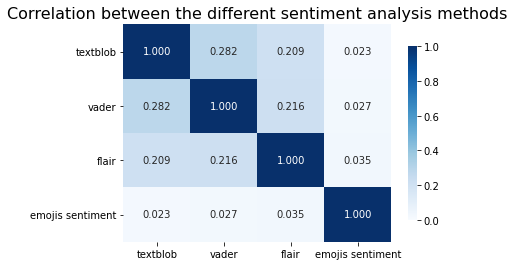

In [151]:
fig, ax = plt.subplots(figsize=(6, 4))

# plot heatmap
sbn.heatmap(df[['textblob', 'vader', 'flair', 'emojis sentiment']].corr(), 
            annot=True, fmt=".3f", cmap='Blues',
            vmin=0, vmax=1, cbar_kws={"shrink": .8})

plt.yticks(rotation=0)
plt.title('Correlation between the different sentiment analysis methods', fontsize=16)
plt.show()

There is no significant correlation between the methods

## 3.8 - Checking if there are data from each day in the period (01 Jan 2020 - 01 Jul 2021)

In [172]:
print(f'Date from the first record: {df.iloc[0]["date"]}')
print(f'Date from the last record: {df.iloc[-1]["date"]}')

Date from the first record: 2021-06-30 00:00:00
Date from the last record: 2019-12-31 00:00:00


Checking if there are any missing days in the dataframe

In [176]:
# How many days are in this period?
date1 = df.iloc[0]["date"]
date2 = df.iloc[-1]["date"]

date1-date2

Timedelta('547 days 00:00:00')

In [177]:
df['date'].nunique()

548

In [180]:
date1 = datetime.strptime('2021-06-02', '%Y-%m-%d')
date2 = datetime.strptime('2021-06-01', '%Y-%m-%d')

date1-date2

datetime.timedelta(days=1)

The dataframe contains values for each day in the period

## 3.9 - Creating the dataframes with the mean values

We are going to test two possibilities:

1. Use the mean value from all samples from each day

2. Use the mean value from the top 5 tweets (considering the number of likes) from each day

### 3.9.1 - Mean value from all samples from each day

In [186]:
all_tweets_df = df.groupby('date').mean()[['textblob', 'vader', 'flair', 'emojis sentiment']]
all_tweets_df.head(2)

,textblob,vader,flair,emojis sentiment
date,,,,
2019-12-31,0.428571,0.428571,0.714286,0.000000
2020-01-01,0.214286,0.190476,0.000000,0.047619


In [187]:
all_tweets_df = all_tweets_df.sort_values('date', ascending=False)
all_tweets_df.head(2)

,textblob,vader,flair,emojis sentiment
date,,,,
2021-06-30,0.119512,0.087805,0.039024,0.053659
2021-06-29,0.117188,0.080078,0.015625,0.039062


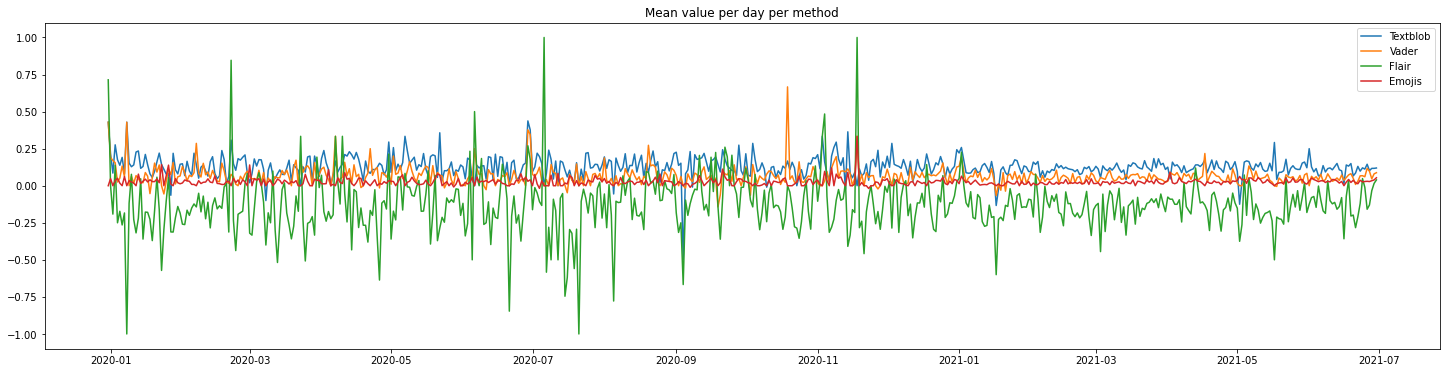

In [189]:
plt.figure(figsize=(25, 6))
plt.plot(all_tweets_df['textblob'], label='Textblob')
plt.plot(all_tweets_df['vader'], label='Vader')
plt.plot(all_tweets_df['flair'], label='Flair')
plt.plot(all_tweets_df['emojis sentiment'], label='Emojis')

plt.title('Mean value per day per method')

plt.legend()
plt.show()

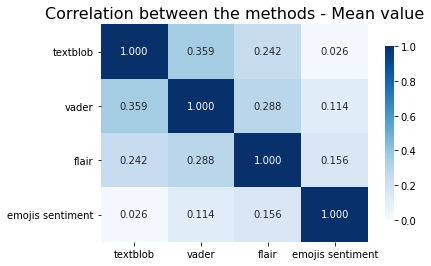

In [191]:
fig, ax = plt.subplots(figsize=(6, 4))

# plot heatmap
sbn.heatmap(all_tweets_df.corr(), 
            annot=True, fmt=".3f", cmap='Blues',
            vmin=0, vmax=1, cbar_kws={"shrink": .8})

plt.yticks(rotation=0)
plt.title('Correlation between the methods - Mean value', fontsize=16)
plt.show()

In [192]:
# Save the results into a json file
# all_tweets_df.to_json('results_all_tweets.json')

In [205]:
# Load the dataframe from the json file
# all_tweets_df = pd.read_json('results_all_tweets.json')

### 3.9.2 - Mean value from all samples from top 5

In [202]:
df.head(2)

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user,emojis,formated tweets,textblob,vader,flair,emojis sentiment
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,1625097600000,1625270400000,1625443200000,1,None,moreira year brazilian icon recently explained...,0,0,1,0
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,1625097600000,1625270400000,1625443200000,1,None,future leader beautiful community many women e...,1,0,1,0


In [229]:
# Extract the top 5 values
days = df['date'].unique()

# DataFrame with the top5 tweets (in terms of number of likes)
top5_df = pd.DataFrame()

for day in days:
    if df[df['date'] == day].shape[0] >= 5:
        temp_df = df[df['date'] == day].sort_values('likes_count', ascending=False)[:5]
    else:
        temp_df = df[df['date'] == day].sort_values('likes_count', ascending=False)
    
    top5_df = pd.concat([top5_df, temp_df])

In [230]:
top5_df.groupby('date').count()['tweet']

date
2019-12-31    5
2020-01-01    5
2020-01-02    5
2020-01-03    5
2020-01-04    5
             ..
2021-06-26    5
2021-06-27    5
2021-06-28    5
2021-06-29    5
2021-06-30    5
Name: tweet, Length: 548, dtype: int64

In [235]:
# Check the number of days with less than 5 tweets
cnt = 0

for item in enumerate(top5_df.groupby('date').count()['tweet'] < 5):
    if item:
        cnt += 1

print(f'Number of days with less than 5 tweets: {cnt}')

Number of days with less than 5 tweets: 548


In [236]:
top5_df = top5_df.groupby('date').mean()[['textblob', 'vader', 'flair', 'emojis sentiment']]
top5_df.head(2)

,textblob,vader,flair,emojis sentiment
date,,,,
2019-12-31,0.4,0.6,1.0,0.0
2020-01-01,0.2,0.2,0.6,0.0


In [238]:
top5_df = top5_df.sort_values('date', ascending=False)
top5_df.head(2)

,textblob,vader,flair,emojis sentiment
date,,,,
2021-06-30,0.0,0.0,-1.0,0.0
2021-06-29,0.4,0.0,0.2,0.0


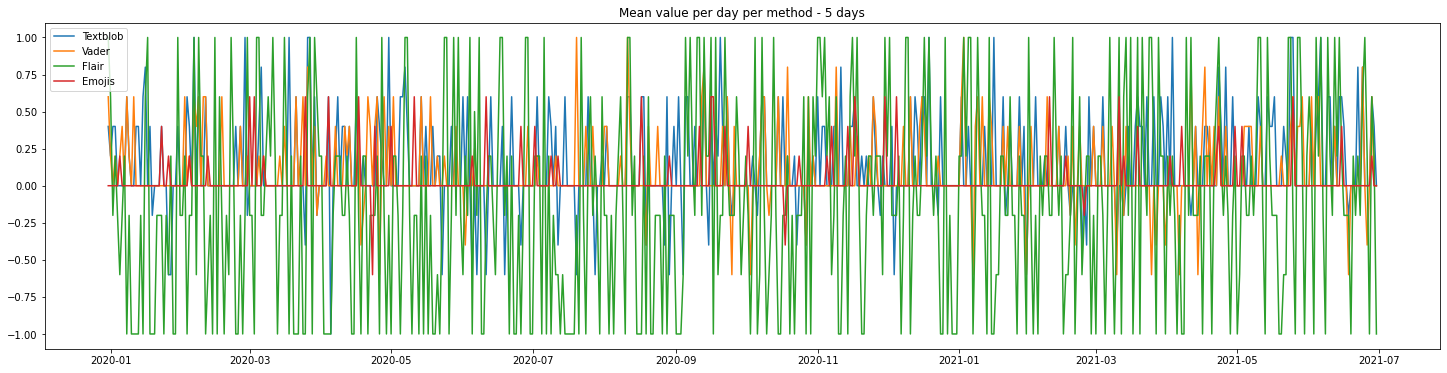

In [239]:
plt.figure(figsize=(25, 6))
plt.plot(top5_df['textblob'], label='Textblob')
plt.plot(top5_df['vader'], label='Vader')
plt.plot(top5_df['flair'], label='Flair')
plt.plot(top5_df['emojis sentiment'], label='Emojis')

plt.title('Mean value per day per method - 5 days')

plt.legend()
plt.show()

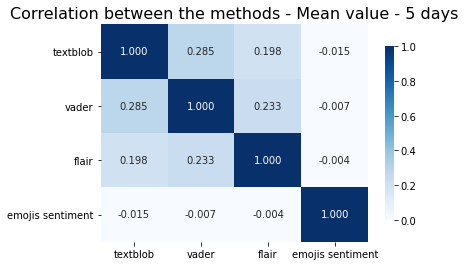

In [240]:
fig, ax = plt.subplots(figsize=(6, 4))

# plot heatmap
sbn.heatmap(top5_df.corr(), 
            annot=True, fmt=".3f", cmap='Blues',
            vmin=0, vmax=1, cbar_kws={"shrink": .8})

plt.yticks(rotation=0)
plt.title('Correlation between the methods - Mean value - 5 days', fontsize=16)
plt.show()

In [241]:
# Save the results into a json file
top5_df.to_json('results_top5_tweets.json')

In [ ]:
# Load the dataframe from the json file
# top5_df = pd.read_json('results_top5_tweets.json')

In [1]:
import pandas as pd

In [6]:
df = pd.read_json('raw_sentiment_analysis_results.json')
df.drop(['vader', 'flair', 'emojis sentiment'], axis=1).head()

,id,date,tweet,hashtags,username,retweets_count,likes_count,replies_count,date + 1d,date + 3d,date + 5d,super user,emojis,formated tweets,textblob
0,1410373845761073158,2021-06-30,"Cid Moreira, a 93-year-old Brazilian TV icon, ...",[bitcoin],bitcoinmagazine,417,2694,79,1625097600000,1625270400000,1625443200000,1,None,moreira year brazilian icon recently explained...,-0.146
1,1410089792453423105,2021-06-30,A future leader in #bitcoin and the beautiful ...,[bitcoin],gvictoriab,19,422,20,1625097600000,1625270400000,1625443200000,1,None,future leader beautiful community many women e...,0.375
2,1410154117855653888,2021-06-30,The #BTC 50-week EMA (blue) is an approximatel...,"[btc, crypto, bitcoin]",rektcapital,60,468,28,1625097600000,1625270400000,1625443200000,1,None,week blue approximately confluent support week...,-0.023
3,1410154779985186817,2021-06-30,"As with everything in bitcoin, this is not opt...",[],saifedean,25,232,11,1625097600000,1625270400000,1625443200000,1,None,everything bitcoin optional agreement irreleva...,0.000
4,1410155249617223688,2021-06-30,Initial rejection for #BTC at the top of this ...,"[btc, crypto, bitcoin]",rektcapital,31,268,23,1625097600000,1625270400000,1625443200000,1,None,initial rejection downtrending wedging structu...,0.000
